In [22]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from ydata_profiling import ProfileReport

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df[data.target_names[0]] = data.target

In [25]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
X = df.drop(columns=[data.target_names[0]]).to_numpy()
y = df[data.target_names[0]].to_numpy()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [28]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [29]:
def convertToBatch(X, y, batch_size=32, type_data='train'):

  shuffle = True if type_data == 'train' else False
  df = TensorDataset(X, y)
  df_loader = DataLoader(df, batch_size, shuffle)
  return df_loader

In [31]:
train_dataset = convertToBatch(X_train, y_train, 164, 'train')
val_dataset = convertToBatch(X_val, y_val, 164, 'valid')
test_dataset = convertToBatch(X_test, y_test, 164, 'test')

In [121]:
class ModelPredictPrice(nn.Module):
  def __init__(self, input_features, output_feautures, pct_dropout=0.3):
    super(ModelPredictPrice, self).__init__()
    self.stack_layers = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(pct_dropout),
        nn.Linear(in_features=128, out_features=64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(pct_dropout),
        nn.Linear(in_features=64, out_features=32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(pct_dropout),
        nn.Linear(in_features=32, out_features=16),
        nn.BatchNorm1d(16),
        nn.ReLU(),
        nn.Dropout(pct_dropout),
        nn.Linear(in_features=16, out_features=8),
        nn.BatchNorm1d(8),
        nn.ReLU(),
        nn.Linear(in_features=8, out_features=1)
    )

  def forward(self, x):
    return self.stack_layers(x)

In [32]:
def root_mean_squared_error_torch(y_true, y_pred):
    assert y_true.size() == y_pred.size(), "Розміри тензорів повинні співпадати"
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))


In [65]:
def train_one_epoch(train_data, model, opt, loss_fn,
                    reuqularization_type, lamb_reg):
  train_mape, train_loss = [], []
  for i, data in enumerate(train_data):
    X, y = data
    X, y = X.to(device), y.to(device)
    opt.zero_grad()
    y_pred = model(X).squeeze()
    loss = loss_fn(y_pred, y)
    if reuqularization_type == 'L1':
      l1_norm = sum(p.abs().sum() for p in model.parameters())
      loss += lamb_reg * l1_norm.item()
    elif reuqularization_type == 'L2':
      l2_norm = sum(p.pow(2).sum() for p in model.parameters())
      loss += lamb_reg * l2_norm.item()
    mape = root_mean_squared_error_torch(y_true=y, y_pred=y_pred)
    loss.backward()
    opt.step()
    train_mape.append(mape.item())
    train_loss.append(loss.item())
  return train_loss, train_mape


In [34]:
def predic_one_epoch(test_data, trained_model, loss_fn):
  preds, y_true = [], []
  test_mape, test_loss = [], []
  for i, data in enumerate(test_data):
    X, y = data
    X, y = X.to(device), y.to(device)
    y_pred = trained_model(X).squeeze()
    loss = loss_fn(y_pred, y)
    mape = root_mean_squared_error_torch(y_true=y, y_pred=y_pred)
    y_true.extend(y.cpu().numpy())
    preds.extend(y_pred.cpu().numpy())
    test_mape.append(mape.item())
    test_loss.append(loss.item())
  return preds, test_mape, test_loss

In [35]:
def plotting_metrics(epochs, train_metric, test_metric, type='loss'):
  plt.plot([i for i in range(0, epochs)], train_metric, label=f"Train {type}")
  plt.plot([i for i in range(0, epochs)], test_metric, label=f"Valid {type}")
  plt.title(f"Training and valid {type} curves")
  plt.ylabel(f"{type}")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

In [122]:
torch.manual_seed(42)

def result_pipiline(model, loss_fn, opt, epochs):
    res_train_loss, res_train_mape = [], []
    res_test_loss, res_test_mape = [], []
    # params for early stopping
    best_loss = float('inf')
    patience = 10
    for epoch in range(1, epochs+1):
      running_loss = 0.0
      model.train()
      train_loss, train_mape = train_one_epoch(train_dataset, model, opt, loss_fn, 'L2', 0.001)
      train_loss = np.mean(train_loss)
      train_mape = np.mean(train_mape)
      res_train_loss.append(train_loss)
      res_train_mape.append(train_mape)
      model.eval()
      with torch.inference_mode():
        test_preds, test_mape, test_loss = predic_one_epoch(val_dataset, model, loss_fn)
        test_mape = np.mean(test_mape)
        test_loss = np.mean(test_loss)
        res_test_loss.append(test_loss)
        res_test_mape.append(test_mape)
      # early stopping
      if test_loss < best_loss * 0.95:
        best_loss = test_loss
        patience = 10
      else:
        patience =- 1
        if patience == 0:
          break
      if epoch % 10 == 0:
          print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, RMSE: {train_mape:.2f} | Valid Loss: {test_loss:.5f}, Valid RMSE: {test_mape:.2f}")
    plotting_metrics(epochs, res_train_loss, res_test_loss, 'loss')
    plotting_metrics(epochs, res_train_mape, res_test_mape, 'accuracy')

    return res_test_loss, res_test_mape,res_train_mape,  res_train_loss, model

Epoch: 10 | Loss: 1.38031, RMSE: 1.02 | Valid Loss: 0.74683, Valid RMSE: 0.86
Epoch: 20 | Loss: 1.21572, RMSE: 0.93 | Valid Loss: 0.65948, Valid RMSE: 0.81
Epoch: 30 | Loss: 1.11599, RMSE: 0.88 | Valid Loss: 0.66568, Valid RMSE: 0.81
Epoch: 40 | Loss: 1.06993, RMSE: 0.85 | Valid Loss: 0.64171, Valid RMSE: 0.80
Epoch: 50 | Loss: 1.04436, RMSE: 0.84 | Valid Loss: 0.59425, Valid RMSE: 0.77
Epoch: 60 | Loss: 1.04018, RMSE: 0.83 | Valid Loss: 0.56763, Valid RMSE: 0.75
Epoch: 70 | Loss: 1.01167, RMSE: 0.82 | Valid Loss: 0.55487, Valid RMSE: 0.74
Epoch: 80 | Loss: 1.00286, RMSE: 0.81 | Valid Loss: 0.58843, Valid RMSE: 0.76
Epoch: 90 | Loss: 0.97931, RMSE: 0.80 | Valid Loss: 0.54099, Valid RMSE: 0.73
Epoch: 100 | Loss: 0.97795, RMSE: 0.80 | Valid Loss: 0.54009, Valid RMSE: 0.73
Epoch: 110 | Loss: 0.96551, RMSE: 0.79 | Valid Loss: 0.52535, Valid RMSE: 0.72
Epoch: 120 | Loss: 0.96048, RMSE: 0.79 | Valid Loss: 0.58611, Valid RMSE: 0.76
Epoch: 130 | Loss: 0.95226, RMSE: 0.78 | Valid Loss: 0.53788,

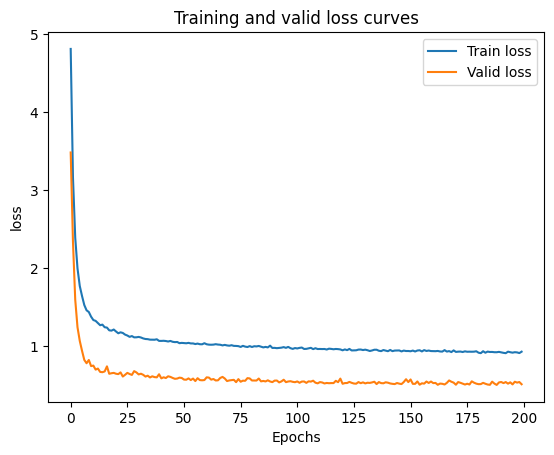

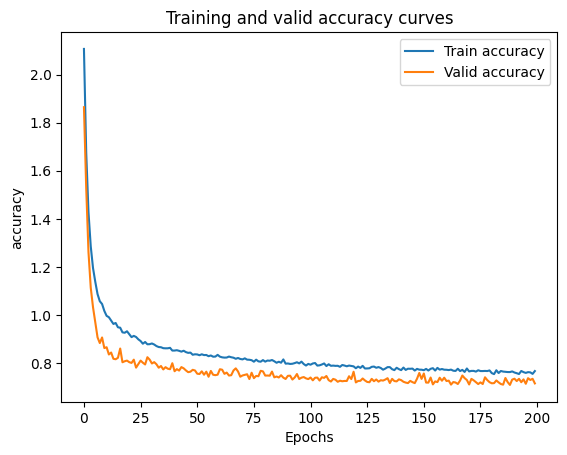

In [123]:
model = ModelPredictPrice(input_features=8, output_feautures=1, pct_dropout=0.4).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.001)
res_test_loss, res_test_mape,res_train_mape,  res_train_loss, model = result_pipiline(model, loss_fn, opt, epochs=200)

Predictions fore test data

In [125]:
model.eval()
test_loss = []
test_rmse = []
predictions, y_true = [],[]
with torch.inference_mode():
    for X_batch, y_batch in test_dataset:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch).squeeze()
        predictions.append(y_pred)
        y_true.append(y_batch)
        loss = loss_fn(y_pred, y_batch)
        test_loss.append(loss.item())
        rmse = root_mean_squared_error_torch(y_true=y_batch, y_pred=y_pred)
        test_rmse.append(rmse.item())
print(f"Loss: {np.mean(test_loss):.5f}, RMSE: {np.mean(test_rmse):.2f}")

Loss: 0.51146, RMSE: 0.71


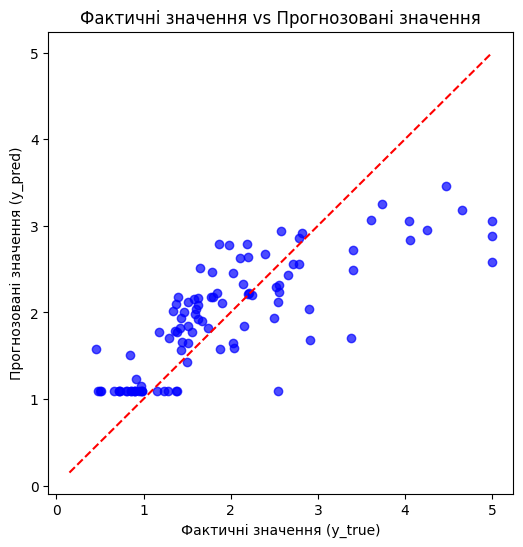

In [127]:
plt.figure(figsize=(6, 6))
real_vals = torch.cat(y_true, dim=0).to('cpu')
preds = torch.cat(predictions, dim=0).to('cpu')
plt.scatter(real_vals[:100], preds[:100], alpha=0.7, color="blue")
plt.plot([min(real_vals), max(real_vals)], [min(real_vals), max(real_vals)], color="red", linestyle="--")
plt.xlabel("Фактичні значення (y_true)")
plt.ylabel("Прогнозовані значення (y_pred)")
plt.title("Фактичні значення vs Прогнозовані значення")
plt.show()


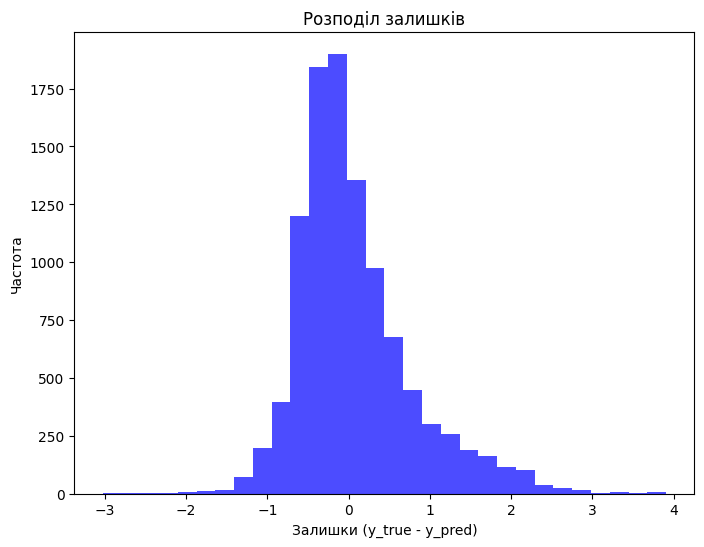

In [129]:
plt.figure(figsize=(8, 6))
plt.hist(real_vals - preds, bins=30, alpha=0.7, color='blue')
plt.xlabel("Залишки (y_true - y_pred)")
plt.ylabel("Частота")
plt.title("Розподіл залишків")
plt.show()
